In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [7]:
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time

In [8]:
import pydicom as dcm

In [9]:
def image_windowing(img, w_min=-400, w_max=100):
    img_w = img.copy()

    img_w[img_w < w_min] = w_min
    img_w[img_w > w_max] = w_max

    return img_w
    
def image_minmax(img):
    img_minmax = ((img - np.min(img)) / (np.max(img) - np.min(img))).copy()
    img_minmax = (img_minmax * 255).astype(np.uint8)
        
    return img_minmax

In [10]:
class BodyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir,transform=None):
        super().__init__()
        self.transform = transform
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        # Read an image with OpenCV
        x_img = dcm.read_file(x_img)
        y_img = Image.open(y_img)
        
        #s = int(x_img.RescaleSlope)
        #b = int(x_img.RescaleIntercept)
        #x_img = s * x_img.pixel_array + b

        x_img= x_img.pixel_array
        x_img=image_windowing(x_img)
        x_img=image_minmax(x_img)
        #x_img = np.expand_dims(x_img,1)
        #x_img=np.array(x_img)
        
        if x_img.shape[0] == 512 or x_img.shape[1] == 512:
            old_x, old_y = x_img.shape[0], x_img.shape[1]
            x = (x_img.shape[0] - 512) // 2
            y = (x_img.shape[1] - 512) // 2
            x_img = x_img[x : old_x-x, y : old_y-y]
            x_img = x_img[:512, :512]
#             x_img = cv2.resize(x_img, (256,256), cv2.INTER_AREA)
            x_img = cv2.cvtColor(x_img, cv2.COLOR_GRAY2BGR)
#             x_img = cv2.cvtColor(x_img, cv2.COLOR_BGR2GRAY)
#             print(x_img.shape)
#             x_img = cv2.resize(x_img, (512,512), cv2.INTER_AREA)
            x_img = np.transpose(x_img,(2,0,1))
        #x_img[idx]=x_img   
#         x_img = torch.tensor(x_img)
        x_img=x_img.astype(np.float32)/255
#         print(x_img.shape)
        y_img= np.array(y_img)
        y_img=y_img.astype(np.float32)

        
#         x_img= x_img.pixel_array
#         x_img=image_windowing(x_img)
#         x_img=image_minmax(x_img)
#         x_img = np.expand_dims(x_img,1)
#         x_img = np.transpose(x_img,(1,0,2))
#         y_img= np.array(y_img)
       
       
        
       
        return x_img, y_img 

In [11]:
# class BodyDataset(torch.utils.data.Dataset):
#     def __init__(self, x_dir, y_dir,transform=None):
#         super().__init__()
#         self.transform = transform
#         self.x_img = x_dir
#         self.y_img = y_dir   

#     def __len__(self):
#         return len(self.x_img)

#     def __getitem__(self, idx):
#         x_img = self.x_img[idx]
#         y_img = self.y_img[idx]
#         # Read an image with OpenCV
#         x_img = dcm.read_file(x_img)
#         y_img = Image.open(y_img)
        
#         s = int(x_img.RescaleSlope)
#         b = int(x_img.RescaleIntercept)
#         x_img = s * x_img.pixel_array + b

# #         x_img= x_img.pixel_array
#         x_img=image_windowing(x_img)
#         x_img=image_minmax(x_img)
#         x_img = np.expand_dims(x_img,1)
#         x_img = np.transpose(x_img,(1,0,2))
#         x_img=np.array(x_img)
#         x_img=x_img.astype(np.float32)/255
        
#         y_img= np.array(y_img)
#         y_img=y_img.astype(np.float32)
       
       
        
       
#         return x_img, y_img 

In [12]:
import imageio
import glob

data_path=sorted(glob.glob( "../input/body-morphometry-kidney-and-tumor/train/DICOM/**/*.dcm",recursive=True ))
label_path=sorted(glob.glob("../input/body-morphometry-kidney-and-tumor/train/Label/**/*.png",recursive = True))

In [16]:
train_dataset = BodyDataset(data_path,label_path)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32,shuffle=False)

In [17]:
len(train_loader)

200

torch.Size([32, 3, 512, 512])


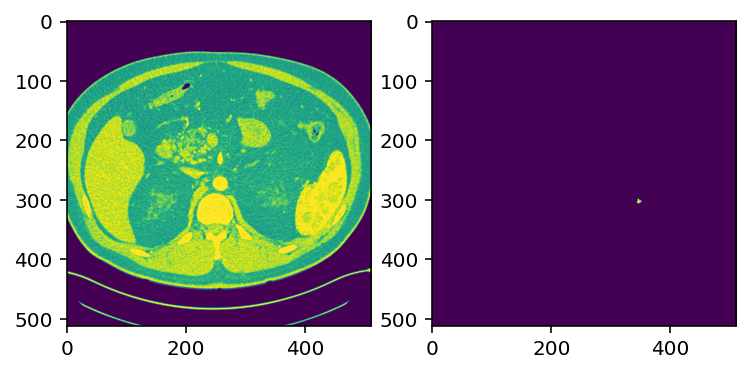

In [18]:
##input과 label이 맞나 확인
images,labels = next(iter(train_loader))

# images= np.transpose(images,(0,3,1,2))
print(images.shape)

y=labels[0].numpy()
x=images[0].numpy()
# print(x[0][500])
#y=labels[0].numpy()
plt.subplot(1,2,1)
# plt.imshow(df_data, cmap='gray', vmin=-400, vmax=100)
plt.imshow(x[0])
plt.subplot(1,2,2)
plt.imshow(y)
plt.show()

In [19]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-gq6yp9y9
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-gq6yp9y9
     |████████████████████████████████| 58 kB 741 kB/s eta 0:00:01
     |████████████████████████████████| 376 kB 1.5 MB/s eta 0:00:01
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88664 sha256=0dcc265edf4065aa3df84f152caae9dad027aa16dae77327a276b26147291dec
  Stored in directory: /tmp/pip-ephem-wheel-cache-4yg_5oa6/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=0a5d6d1479d5093cf27d4f05dd4bbab6986bcdf66317ab33afb3731a85becc17
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrai

In [15]:
# # model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
# model = models.segmentation.deeplabv3_resnet101(pretrained=True)
# # model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)

In [20]:
import segmentation_models_pytorch as smp
model = smp.DeepLabV3(
    encoder_name="resnet34",# choose encoder, e.g. mobilenet_v2 or efficientnet-b7 resnext101_32x8d,timm-res2net101_26w_4s     # use `imagenet` pre-trained weights for encoder initialization 
    encoder_weights="imagenet",
    in_channels=3,
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [21]:
sum([param.nelement() for param in model.parameters()])

26007105

In [22]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [23]:
# def DiceLoss(inputs, targets, smooth=1):

#     #comment out if your model contains a sigmoid or equivalent activation layer
    
#     inputs =F.sigmoid(inputs)       

#     #flatten label and prediction tensors
#     inputs = inputs.view(-1)
#     targets = targets.view(-1)

#     intersection = (inputs * targets).sum()                            
#     dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  

#     return 1 - dice

In [24]:
criterion=smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model.to(device), 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)


In [ ]:
train_logs

In [ ]:
max_score = 0

for i in range(0, 5):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    
    
    # do something (save model, change lr, etc.)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model.state_dict(), 'model_body4.pt')
        print('Model saved!')

Starting epoch =  0


  0%|          | 0/200 [00:00<?, ?it/s]

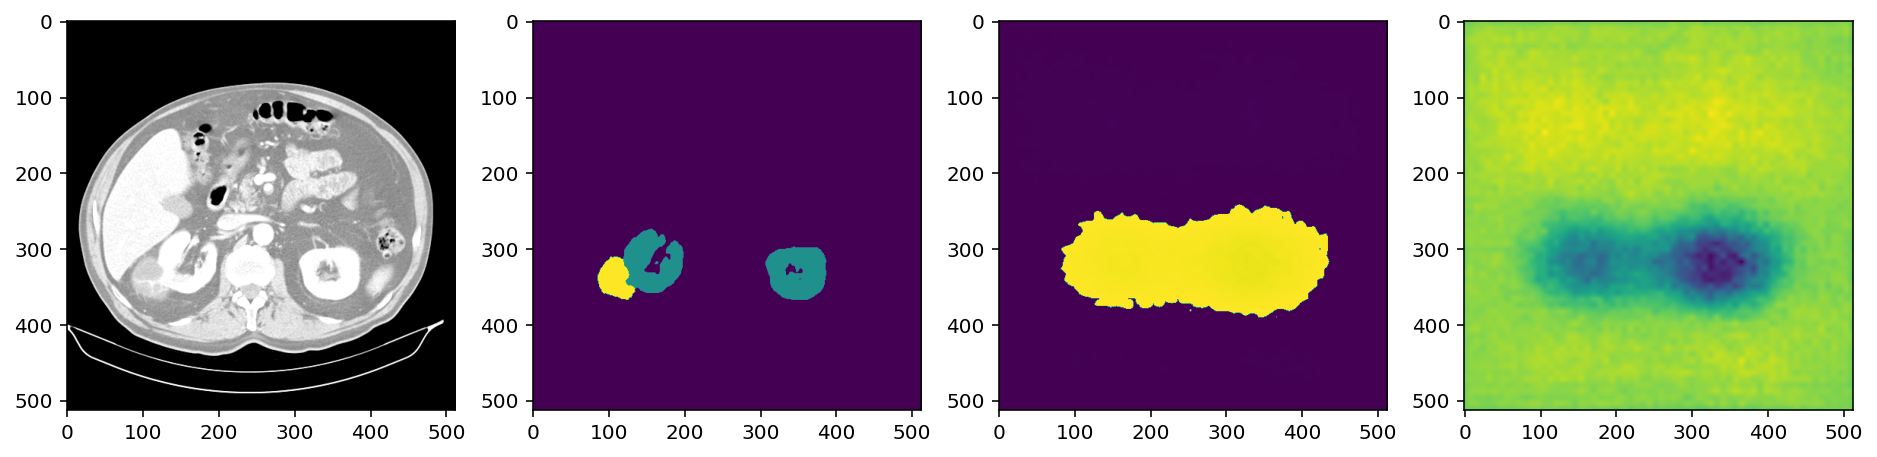

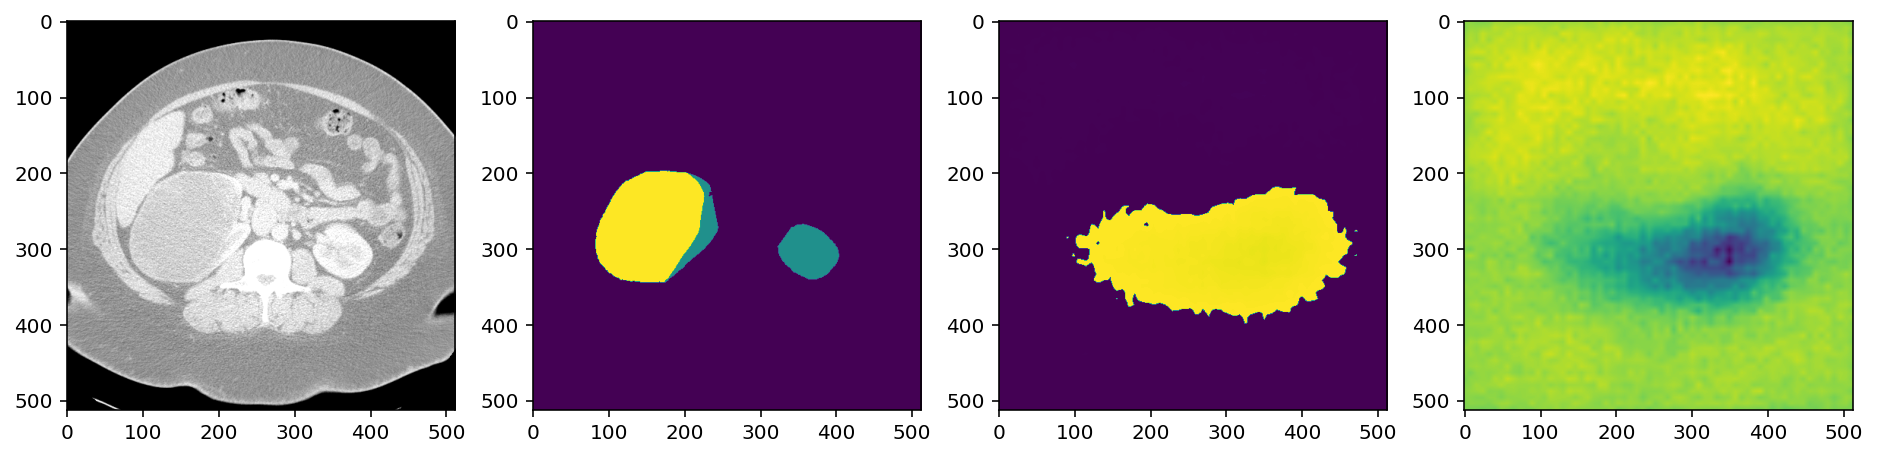

In [ ]:
n_epochs=300
train_loss_min=9999999999999999
train_loss = torch.zeros(n_epochs)
cnt =0
#model=ResNetUNet(3)
#model.load_state_dict(torch.load('model_train_8.pt'))
model.to(device)
for e in np.arange(n_epochs): 
    print('Starting epoch = ', e)

    # Training
    model.train()
    for data,labels in tqdm(train_loader):
     # move tensors to GPU if CUDA is available
       
#         data, labels = torch.float.tensor(data),torch.tensor(labels)
        data, labels = data.to(device), labels.to(device)
#         print(data)
        
    # clear the gradients of all optimized variables
        optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
#         train_logs = train_epoch.run(train_loader)
        
#         logits = torch.nn.Sigmoid()(model(data))
        logits =model(data)
        z=logits.detach().cpu().numpy()
        z = z.astype(np.uint8)
        cnt = cnt+1
        
        if cnt %50==0:
#             print(logits[0][0][500])
#             print(labels[0][300])
#             print(data.shape)
#             print(labels.shape)
#             print(logits.shape)
            # y=torch.squeeze(labels[0])
            y=labels[0].detach().cpu().numpy()
            x=data[0].detach().cpu().numpy()
            a=logits[0].detach().cpu().numpy()
            #y=labels[0].numpy()
            plt.figure(figsize=(16,18))
            plt.subplot(1,4,1)
            plt.imshow(x[0],cmap='gray')
            plt.subplot(1,4,2)
            plt.imshow(y)
            plt.subplot(1,4,3)
            plt.imshow(z[0][0])
            plt.subplot(1,4,4)
            plt.imshow(a[0])
            plt.show()
        
        #print(logits)
    # calculate the batch loss
        loss = criterion(logits, labels)dnc
    # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
    # perform a single optimization step (parameter update)
        optimizer.step()
    # update training loss
        train_loss[e] += loss.item()

    train_loss[e] /= len(train_loader)
    
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(e, train_loss[e]))
    if train_loss[e] <= train_loss_min:
            print('train_loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            train_loss_min,
            train_loss[e]))
            train_loss_min = train_loss[e]
            torch.save(model.state_dict(), 'model_body3.pt')




In [ ]:
model.load_state_dict(torch.load('model_body3.pt'))

In [ ]:
class TestMyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir,transform=None):
        super().__init__()
        self.transform = transform
        self.x_img = x_dir
     

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
     
        # Read an image with OpenCV
        x_img = dcm.dcmread(x_img)
      
        x_img= x_img.pixel_array
        x_img=image_windowing(x_img)
        x_img=image_minmax(x_img)
        #x_img = np.expand_dims(x_img,1)
        #x_img=np.array(x_img)
        
        if x_img.shape[0] == 512 or x_img.shape[1] == 512:
            old_x, old_y = x_img.shape[0], x_img.shape[1]
            x = (x_img.shape[0] - 512) // 2
            y = (x_img.shape[1] - 512) // 2
            x_img = x_img[x : old_x-x, y : old_y-y]
            x_img = x_img[:512, :512]
#             x_img = cv2.resize(x_img, (256,256), cv2.INTER_AREA)
            x_img = cv2.cvtColor(x_img, cv2.COLOR_GRAY2BGR)
#             x_img = cv2.cvtColor(x_img, cv2.COLOR_BGR2GRAY)
#             print(x_img.shape)
#             x_img = cv2.resize(x_img, (512,512), cv2.INTER_AREA)
            x_img = np.transpose(x_img,(2,0,1))
        #x_img[idx]=x_img   
#         x_img = torch.tensor(x_img)
        x_img=x_img.astype(np.float32)/255

       
        return x_img

In [ ]:

test_dataset=sorted(glob.glob( "../input/body-morphometry-kidney-and-tumor/test/DICOM/**/*.dcm",recursive=True ))
test_dataset=TestMyDataset(test_dataset)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
len(test_dataloader)

In [ ]:
def rle_encode(mask_image):
    pixels = mask_image.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    return runs

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


preds_string=[]
preds = []
model.to(device)
cnt=0
t=0
for data in tqdm(test_dataloader):
    cnt+=1

    data= data.to(device)
#     data=data.unsqueeze(1)
    # forward pass: compute predicted outputs by passing inputs to the model
#     preds.append(model(data).detach().cpu())
    logits = model(data).detach().cpu()
    
    z=logits.detach().cpu().numpy()
    z = z.astype(np.uint8)
    preds.append(z)
    
    if cnt%64==0:
#         y=preds[cnt-1][0][0]
#         y=y.numpy()
        y=logits[0][0].detach().cpu().numpy()
        x=data.detach().cpu().numpy()
        x = x[0][0]
        #y=labels[0].numpy()
        plt.figure(figsize=(16,18))
        plt.subplot(1,3,1)
        plt.imshow(x)
        plt.subplot(1,3,2)
        plt.imshow(z[0][0])
        plt.subplot(1,3,3)
        plt.imshow(y)
        plt.show()
    

for i in tqdm(range(0, len(preds),64)):
    sample = preds[i:i+64]
    for label_code in [1,2]:
        tmp=[]
        for s in sample:
            s = np.equal(s, label_code).flatten()*1
            tmp+=s.tolist()
        enc = rle_to_string(rle_encode(np.array(tmp)))

        preds_string.append(enc)



In [ ]:
preds

In [ ]:
preds_string=[]
for i in tqdm(range(0, len(preds),64)):
    sample = preds[i:i+64]
    for label_code in [1,2]:
        tmp=[]
        for s in sample:
            s = np.equal(s, label_code)*1
            print(s)
            tmp+=s.tolist()
        enc = rle_to_string(rle_encode(np.array(tmp)))

        preds_string.append(enc)

In [ ]:
len(tmp)

In [ ]:
preds_string

In [ ]:
preds[0].shape

In [ ]:
len(preds_string)

In [ ]:
##input과 label이 맞나 확인
y=sample[0][0][0]
#y=torch.squeeze(labels[0])
y=y.numpy()
#x=images[0].numpy()
#y=labels[0].numpy()
plt.subplot(1,2,1)
#plt.imshow(x,cmap='gray')
#plt.subplot(1,2,2)
plt.imshow(y,cmap='gray')
plt.show()

In [ ]:

sample_submission = pd.read_csv('../input/body-morphometry-kidney-and-tumor/sample_submission.csv')
sample_submission['EncodedPixels'] = preds_string
sample_submission.to_csv('submission.csv', index=False)